# Getting started: Maximum Logit Score on MNIST

This notebook aims at introducing the core features of `oodeel`, including :
* Instanciation of `OODDataset` to load a dataset from `tensorflow_datasets` catalog and to organize in-distribution and out-of-distribution data.
* Preparation of a `tf.data.Dataset` ready for scoring and training.
* A simple utils to train neural nets (adapted when in-distribution is not a standard dataset, such as a subset of class from a dataset)
* Instanciation of `OODModel` based on an already trained model, that is used for scoring data.
* Some evaluation metrics to assess the quality of OOD detection.

First, some required imports.

In [1]:
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2" 
import tensorflow as tf
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch 

from oodeel.methods import MLS
from oodeel.eval.metrics import bench_metrics
from oodeel.datasets import OODDataset
from oodeel.models.training_funs import train_convnet_classifier_tf, train_convnet_classifier_torch

from sklearn.metrics import accuracy_score, roc_auc_score

import warnings
warnings.filterwarnings("ignore")

Note that models are saved at *~/.oodeel/saved_models* by default. Change the following cell for a custom path.

In [2]:

model_path = os.path.expanduser("~/") + ".oodeel/saved_models"
os.makedirs(model_path, exist_ok=True)

## MNIST vs Fashion MNIST

* In-distribution data: MNIST 
* Out-of-distribution data: Fashion MNIST

### Load and prepare the datasets

This is performed using the class `OODDataset`. First, load the datasets.

/!\ We denote In-Distribution (ID) data with `_in` and Out-Of-Distribution (OOD) data with `_out` to avoid confusion with OOD detection which is the name of the task, and is therefore used to denote core classes such as `OODDataset` and `OODModel`.

Before loading, choose your backend (tensorflow or torch). You only have to give it as input to OODDataset and that's it. The rest of the code will be exactely the same regardless of the library (except for model loading - **for now**).

Here, we load our datasets from tensorflow_dataset. When backend is "torch", the datasets are conerted on the fly and loaded on VRAM as torch tensors.

In [3]:
backend = "torch"

oods_in = OODDataset(
    'mnist', 
    split="test", 
    backend=backend, 
    load_from_tensorflow_datasets=True
)
oods_out = OODDataset(
    'fashion_mnist', 
    split="test", 
    backend=backend, 
    load_from_tensorflow_datasets=True
)
oods_train = OODDataset(
    'mnist', 
    split="train", 
    backend=backend, 
    load_from_tensorflow_datasets=True
)

Then, prepare the dataset for scoring and/or training using `.prepare` method.

In [4]:
def preprocess_fn(*inputs):
    x = inputs[0] / 255
    return tuple([x] + list(inputs[1:]))

batch_size = 128

ds_in = oods_in.prepare(batch_size=batch_size, preprocess_fn=preprocess_fn)
ds_out = oods_out.prepare(batch_size=batch_size, preprocess_fn=preprocess_fn)
ds_train = oods_train.prepare(batch_size=batch_size, preprocess_fn=preprocess_fn, shuffle=True)

Train or load a model on in-distribution data (MNIST).

... a keras model ...

In [5]:
model_path_mnist = os.path.join(model_path, "mnist_model.h5")

try:
    model = tf.keras.models.load_model(model_path_mnist)
    
except OSError:
    train_config = {
        "input_shape": (28, 28, 1),
        "num_classes": 10,
        "batch_size": 128,
        "is_prepared": True,
        "epochs": 5,
        "save_dir": model_path_mnist,
        "validation_data": ds_in#.get_dataset() #ds_in is actually the test set of MNIST
    }

    model = train_convnet_classifier_tf(ds_train, **train_config) #ds_train is actually the train set of MNIST
    model.summary()

... or a pytorch one.

In [5]:
model_path_mnist = os.path.join(model_path, "mnist_model_torch/best.pt")
try:
    model = torch.load(model_path_mnist)
    
except OSError:
    train_config = {
        "input_shape": (1, 28, 28),
        "num_classes": 10,
        "batch_size": 128,
        "is_prepared": True,
        "epochs": 5,
        "save_dir": model_path_mnist,
        "validation_data": ds_in#.get_dataset() #ds_in is actually the test set of MNIST
    }

    model = train_convnet_classifier_torch(ds_train, **train_config) #ds_train is actually the train set of MNIST

### Maximum Logit Score (MLS)

Return an OOD score based on the maximum value of the output logits. Introduced in [Open-Set Recognition: a Good Closed-Set Classifier is All You Need?](http://arxiv.org/abs/2110.06207), ICLR 2022.

In [6]:
%load_ext autoreload
%autoreload 2
oodmodel = MLS()

oodmodel.fit(model)
scores_in = oodmodel.score(ds_in)
scores_out = oodmodel.score(ds_out)

Compute the evaluation metrics based on the scores of the test data, and visualize the scores histogram.

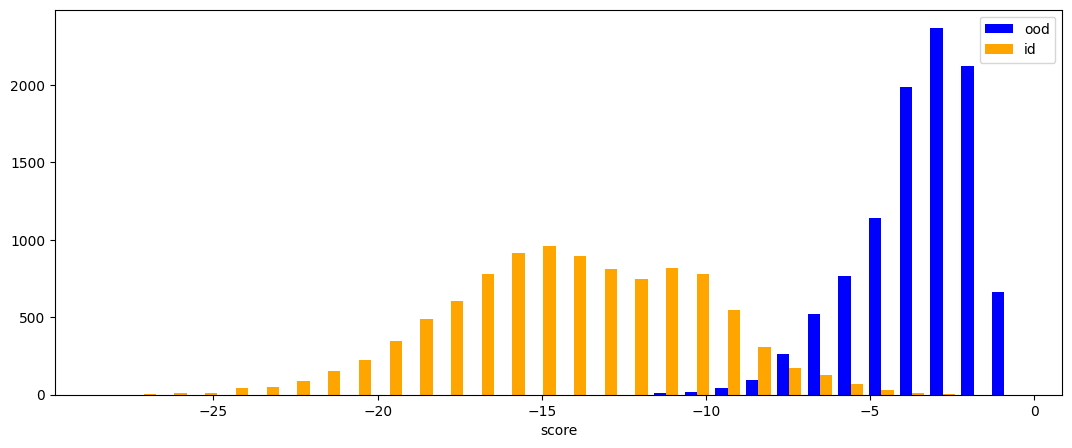

auroc             0.995777
fpr95tpr          0.021700
accuracy_score    0.970000
roc_auc_score     0.995777
dtype: float64


In [7]:
metrics = bench_metrics(
    (scores_in, scores_out),  
    metrics = ["auroc", "fpr95tpr", accuracy_score, roc_auc_score], 
    threshold = -7.5 # visually chosen based on the plot
    )

def plot_hist(scores_in, scores_out, bins, log=False):
    if log:
        minim = np.min([np.min(scores_in), np.min(scores_out)])
        scores_in_ = scores_in - 2 * minim + np.min(scores_in[np.where(scores_in != minim)])
        scores_out_ = scores_out - 2 * minim + np.min(scores_in[np.where(scores_in != minim)])
        _, bins = np.histogram(np.concatenate([scores_in_, scores_out_]), bins=30)
        logbins = np.logspace(np.log10(bins[0]),np.log10(bins[-1]),len(bins))
        plt.xscale('log')
        plt.xlabel("score (normalized log axis)")
    else:
        logbins=bins
        scores_in_ = scores_in 
        scores_out_ = scores_out
        plt.xlabel("score")
    plt.hist((scores_out_, scores_in_), bins=logbins, color=("blue", "orange"), label=("ood", "id"))
    plt.legend()
    plt.show()

plt.figure(figsize=(13, 5))
plot_hist(scores_in, scores_out, 30)
metrics = pd.Series(metrics)
print(metrics)


### Maximum Softmax Probability (MSP)

It is possible to do the same after the softmax activation. Introduced in [A Baseline for Detecting Misclassified and Out-of-Distribution Examples in Neural Networks](http://arxiv.org/abs/1610.02136), ICLR 2017.

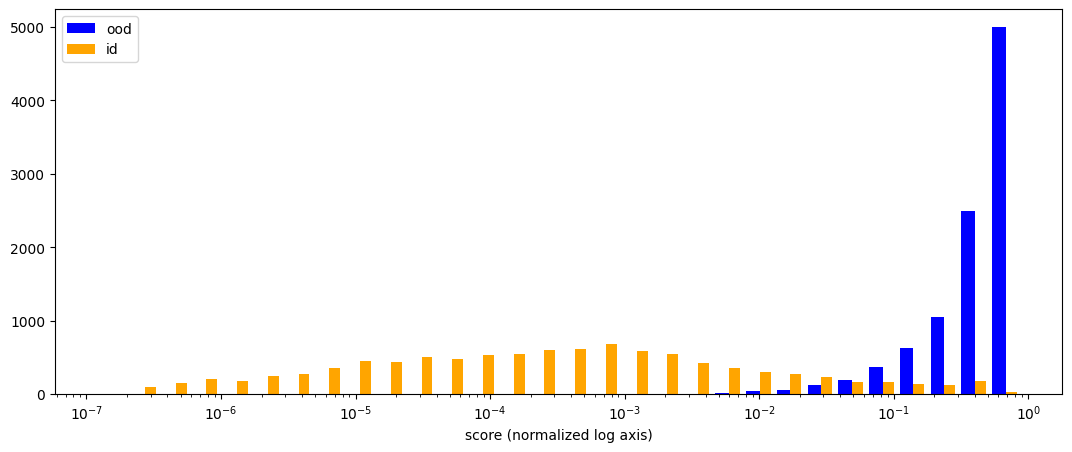

auroc             0.985409
fpr95tpr          0.060900
accuracy_score    0.946550
roc_auc_score     0.985409
dtype: float64


In [11]:
oodmodel = MLS(output_activation="softmax")
oodmodel.fit(model)
scores_in = oodmodel.score(ds_in)
scores_out = oodmodel.score(ds_out)

metrics = bench_metrics(
    (scores_in, scores_out),  
    metrics = ["auroc", "fpr95tpr", accuracy_score, roc_auc_score], 
    threshold = -0.95 # visually chosen based on the plot
    )

plt.figure(figsize=(13, 5))
plot_hist(scores_in, scores_out, 30, log=True)
metrics = pd.Series(metrics)
print(metrics)

## MNIST (0-4) vs MNIST (5-9)

* In-distribution data: MNIST (0-4)
* Out-of-distribution data: MNIST (5-9)

We can repeat the procedure in an open-set-recognition or semantic OOD setting by considering a subset of MNIST classes as in-distribution and another subset as out-of-distribution. The datasets are constructed using the `OODDataset` method `.assign_ood_labels_by_class`. First load and split the dataset.

In [8]:
oods_train = OODDataset(
    'mnist', 
    split="train", 
    backend=backend, 
    load_from_tensorflow_datasets=True
)
oods_test = OODDataset(
    'mnist', 
    split="test", 
    backend=backend, 
    load_from_tensorflow_datasets=True
)

batch_size = 128
inc_labels = [0, 1, 2, 3, 4]
oods_train, _ = oods_train.assign_ood_labels_by_class(in_labels=inc_labels)
oods_in, oods_out = oods_test.assign_ood_labels_by_class(in_labels=inc_labels)

UnboundLocalError: local variable 'dataset' referenced before assignment

Then prepare the datasets for scoring and/or training.

In [9]:

def preprocess_fn(*inputs):
    x = inputs[0] / 255
    return tuple([x] + list(inputs[1:]))

ds_train = oods_train.prepare(batch_size=batch_size, preprocess_fn=preprocess_fn, shuffle=True)
ds_in = oods_in.prepare(batch_size=batch_size, with_ood_labels=False, preprocess_fn=preprocess_fn)
ds_out = oods_out.prepare(batch_size=batch_size, with_ood_labels=False, preprocess_fn=preprocess_fn)


Train or load the model.

keras

In [11]:
model_path_mnist_04 = os.path.join(model_path, "mnist_model_0-4.h5")

try:
    model = tf.keras.models.load_model(model_path_mnist_04)
    
except OSError:
    train_config = {
        "input_shape": (28, 28, 1),
        "num_classes": 10,
        "is_prepared": True,
        "batch_size": 128,
        "epochs": 5,
        "save_dir": model_path_mnist_04,
        "validation_data": ds_in #ds_in is actually the test set of MNIST
    }

    model = train_convnet_classifier_tf(ds_train, **train_config) #ds_train is actually the train set of MNIST

pytorch

In [10]:
model_path_mnist = os.path.join(model_path, "mnist_model_torch_0-4/best.pt")
try:
    model = torch.load(model_path_mnist)
    
except OSError:
    train_config = {
        "input_shape": (1, 28, 28),
        "num_classes": 10,
        "batch_size": 128,
        "is_prepared": True,
        "epochs": 5,
        "save_dir": model_path_mnist,
        "validation_data": ds_in#.get_dataset() #ds_in is actually the test set of MNIST
    }

    model = train_convnet_classifier_torch(ds_train, **train_config) #ds_train is actually the train set of MNIST

Epoch 5/5 [Val]: 100%|██████████| 79/79 [00:00<00:00, 878.71it/s, Loss=0.048, Acc=0.984]


### Maximum Logit Score (MLS)

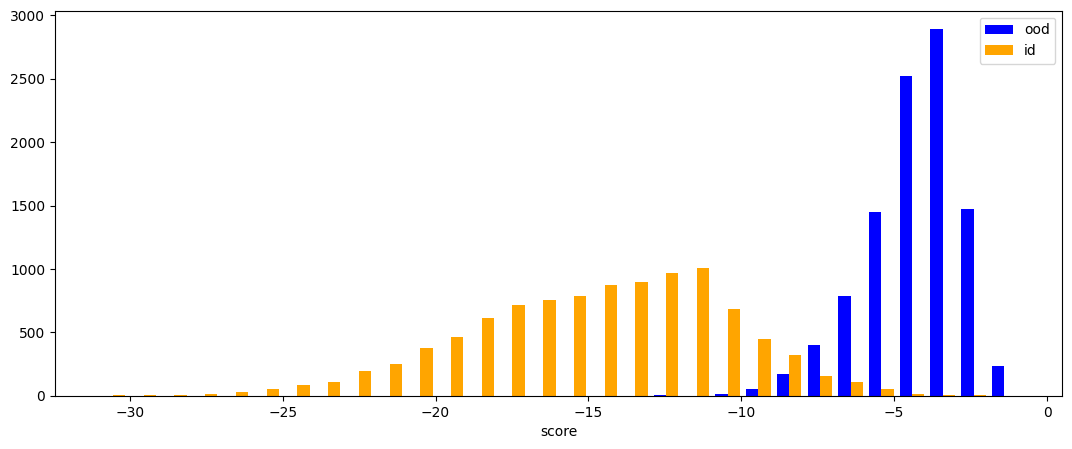

auroc             0.995296
fpr95tpr          0.022800
accuracy_score    0.967400
roc_auc_score     0.995296
dtype: float64


In [11]:
oodmodel = MLS()
oodmodel.fit(model)
scores_in = oodmodel.score(ds_in)
scores_out = oodmodel.score(ds_out)


metrics = bench_metrics(
    (scores_in, scores_out),  
    metrics = ["auroc", "fpr95tpr", accuracy_score, roc_auc_score], 
    threshold = -7.5 # visually chosen based on the plot
    )

plt.figure(figsize=(13, 5))
plot_hist(scores_in, scores_out, 30)
metrics = pd.Series(metrics)
print(metrics)

### Maximum Softmax Probability (MSP)

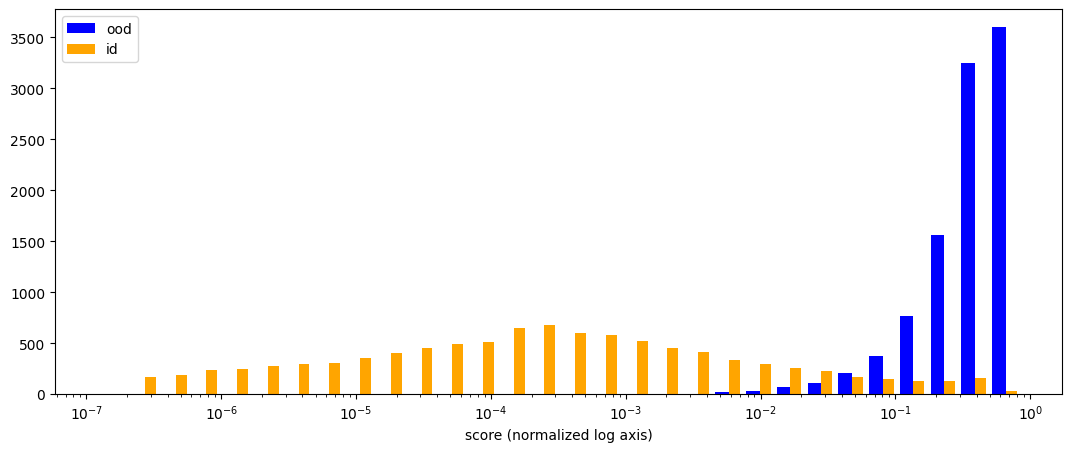

auroc             0.982762
fpr95tpr          0.057600
accuracy_score    0.949200
roc_auc_score     0.982762
dtype: float64


In [12]:
oodmodel = MLS(output_activation="softmax")
oodmodel.fit(model)
scores_in = oodmodel.score(ds_in)
scores_out = oodmodel.score(ds_out)


metrics = bench_metrics(
    (scores_in, scores_out),  
    metrics = ["auroc", "fpr95tpr", accuracy_score, roc_auc_score], 
    threshold = -0.95 # visually chosen based on the plot
    )

plt.figure(figsize=(13, 5))
plot_hist(scores_in, scores_out, 30, log=True)
metrics = pd.Series(metrics)
print(metrics)